In [3]:
import matplotlib.pyplot as plt
from scipy.special import logit, expit
from scipy.stats import gaussian_kde
import numpy as np
plt.style.use('seaborn')
from statsmodels.distributions import ECDF

from seaborn import kdeplot

In [4]:
filenames = ['hpo_implicit_als.dat', 'hpo_implicit_bpr.dat',
             'hpo_lightfm_warp.dat', 'hpo_lightfm_bpr.dat']

In [7]:
for filename in filenames:
    file = open(filename, 'r')
    func_evals = list()
    record=False
    for line in file:
        if record:
            func_evals.append(float(line.strip('\n').split()[-1]))
        if 'All' in line:
            record=True

In [5]:
def plot_fig_label(ax, lab):
    ax.text(0, 1.1, lab, transform=ax.transAxes,
        fontsize=24, va='top', ha='left')

def simple_bootstrap(data, fun=np.mean, n=1000, take = 350):
    return fun(np.random.choice(data, size=(n,take)), axis=1)

def simple_ci(data):
    d_sorted = np.sort(data)
    low = int(d_sorted.shape[0] // (1/0.025))
    high = int(d_sorted.shape[0] // (1/0.975))
    return (d_sorted[low], d_sorted[high])

def simple_ecdf(ranks, maxrank):
    x = np.arange(1, maxrank)
    ecdf = [(ranks<=i).sum()/len(ranks) for i in x]
    return x, ecdf

def plot(nn=False):
    fig, ax = plt.subplots(nrows=2, ncols=1)
    fig.set_figheight(10)
    fig.set_figwidth(7)
    if nn:
        nnranks = np.load('./processed_data/2015_nearest_neighbor.npy')
        mask = nnranks>3

    jits = np.linspace(0.35,4.4, 6)
    np.random.shuffle(jits)
    for count, name in enumerate(filenames):
        #load
        ranks = np.load('./processed_data/'+str(year)+'_'+name+'.npy')
        if nn:
            ranks = ranks[mask]

        #analyse
        bstrap = simple_bootstrap(ranks, take=len(ranks))
        ci = simple_ci(bstrap)
        x,y = simple_ecdf(ranks, 243)

        #plot:
        #A
        ax[0].plot(x,y,'-o', mfc='white', mew=1.5, linewidth=1.5,label=name, c='C'+str(count))

        #B
        out = kdeplot(bstrap, ax=ax[1], shade=True, color='C'+str(count))
        #jit = np.random.uniform()*3+1
        jit = jits[count]
        ax[1].plot([ci[0], ci[1]], [-jit,-jit], lw=5.5, c='C'+str(count),zorder=10)
        ax[1].scatter([np.mean(ci)], [-jit],
                       facecolor='white',
                       edgecolor='C'+str(count),
                       lw=3.5,
                       zorder=20)

    fsize = 14
    ax[1].plot([0.3, 0.5], [1e6, 1e6], c='black', linewidth=3.5, label='95% CI')
    ax[1].set_ylim(-5,25)
    ax[1].set_xlim(-0.01, 0.6)
    ax[1].legend()
    ax[1].set_xlabel('p@3', fontsize=fsize)
    ax[1].set_ylabel('Bootstrap density', fontsize=fsize)
    yt = np.arange(-5,25, 5)
    ax[1].set_yticks(yt)
    ax[1].set_yticklabels(['' for i in yt])

    plot_fig_label(ax[0], 'A.')
    plot_fig_label(ax[1], 'B.')

    ax[0].legend()
    ax[0].set_xlim(0,20)
    ax[0].set_xlabel('Rank', fontsize=fsize)
    ax[0].set_ylabel('ECDF', fontsize=fsize)
    xt = np.arange(1,20,2)
    ax[0].set_xticks(xt)
    ax[0].axvline(3, c='k', linestyle='--', zorder=1)
    plt.tight_layout()

    return fig, ax

In [43]:
#normal tools:
from scipy import sparse
import numpy as np
import copy
import sys
sys.path.append("..")
import utils

from scipy.stats.mstats import rankdata
import matplotlib.pyplot as plt
%matplotlib inline

#learning library:
import lightfm
import implicit

#skopt:
from skopt.space import Real, Integer
from skopt import Optimizer
from sklearn.externals.joblib import Parallel, delayed
from skopt.utils import use_named_args
import skopt

In [ ]:
#this performs multiple repeats of the test/train split, if desired:
def bootstrap(params, interaction_matrix, algorithm_function, repeats):
    results = list()
    for _ in range(repeats):
        #get a train/test split:
        train, test = utils.train_test_split(interaction_matrix, 0.05)
        #train matrix is used to train the model and make predictions:
        pred_matrix = algorithm_function(params,train)
        #test matrix is used to score the predictions:
        results.append(utils.evaluate_predictions(pred_matrix, test, train).mean())
    return np.mean(results)

In [2]:
interaction_matrix = utils.load_subset()

In [3]:
train, test = utils.train_test_split(interaction_matrix, 0.05)

In [6]:
params = utils.read_params('hpo_implicit_bpr')

preds = utils.train_implicit_bpr(params, train)

In [20]:
predictions = copy.copy(preds)

In [21]:
if isinstance(test, sparse.csr_matrix):
    test = test.toarray()
if isinstance(train, sparse.csr_matrix):
    train = train.toarray()
if isinstance(predictions, sparse.csr_matrix):
    predictions = predictions.toarray()

In [26]:
shift_true_pos = train*-10000*preds

In [28]:
ranked = shift_true_pos.argsort(axis=0).argsort(axis=0)

In [32]:
actual_ranks = ranked[test.astype(bool)]

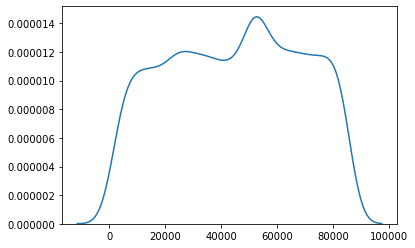

In [33]:
from seaborn import kdeplot
kdeplot(actual_ranks)

In [34]:
#mask the known positives so they won't be calculated in the ranking:
predictions = np.ma.masked_array(predictions, mask=train.astype(bool))

In [45]:
%%time
prediction_ranks = rankdata(-predictions[:,:50], axis=0)

CPU times: user 7.12 s, sys: 148 ms, total: 7.27 s
Wall time: 7.49 s


In [47]:
36*8 / 60

4.8

In [39]:
test_ranks = prediction_ranks[test.astype(bool)]

In [48]:
np.mean(test_ranks)

1833.41115164148

In [49]:
np.median(test_ranks)

429.0

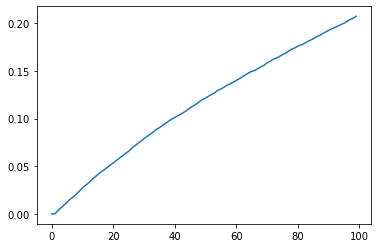

In [44]:
plt.plot([(test_ranks<i).sum() / len(test_ranks) for i in range(100)])

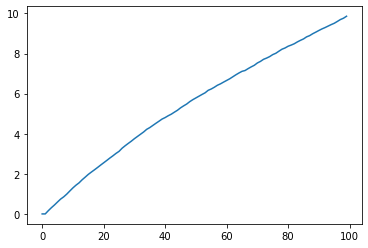

In [52]:
plt.plot([(test_ranks<i).sum()/242 for i in range(100)])

In [19]:
(test.sum(axis=0)==0)

18

In [ ]:
row_mask = np.array(test.sum(axis=1)>0).reshape(-1,)
test_masked = test[row_mask]
get_ranks = test_masked.astype(bool)

In [ ]:
#effect since the algo's are really good at ranking known positives highly.
predictions = np.ma.masked_array(predictions[row_mask], mask=train[row_mask].astype(bool))
#rankdata approach, which correctly handles ties and also thankgod can take masked arrays:
prediction_ranks = rankdata(-predictions, axis=1)

In [ ]:
all_test_ranks = prediction_ranks[get_ranks]
return all_test_ranks